In [200]:
## Import Libraries
import numpy as np
import pandas as pd
import copy

from tqdm.auto import trange

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
import torch.optim as optim

from torchvision import datasets, transforms


import matplotlib.pyplot as plt

# from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import adjusted_rand_score, accuracy_score, davies_bouldin_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

# Used to save data into files
import pickle as pkl
import os

# Used to measure time
import time

In [201]:
## Import train and test dataset, scale them and convert them to data loaders
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.0

train_dataset = datasets.FashionMNIST(
    root="../adv-ml_challenge1/data/",
    train=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)]),
    download=True,
)
print(train_dataset)

test_dataset = datasets.FashionMNIST(
    root="../adv-ml_challenge1/data/",
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)]),
    download=True,
)
print(test_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../adv-ml_challenge1/data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../adv-ml_challenge1/data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )


In [202]:
## Randomly select some images from the training and test dataset

subset_size = 10000

## set a seed for randperm
th.manual_seed(42)

idx = th.randperm(len(train_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

train_subset_loader = DataLoader(train_dataset, sampler=sampler)

idx = th.randperm(len(test_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

test_subset_loader = DataLoader(train_dataset, sampler=sampler)

del idx
del sampler

In [203]:
## Convert the images and their labels to numpy arrays and reshape them to vectors

labels_train = []
train_subset = []
for batch in train_subset_loader:
    data, labels = batch

    train_subset.append(data.numpy().reshape(1, -1))
    labels_train.append(labels.numpy())

train_subset_scaled = np.array(train_subset).reshape(subset_size, -1)
labels_train = np.array(labels_train)

# Creating dictionary of labels for better understanding
description = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

ticks = list(description.keys())
tick_labels = list(description.values())

torch.Size([64, 1, 28, 28])


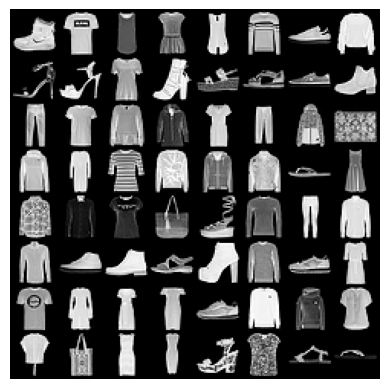

In [204]:
def imshow(img) -> None:
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, axes=(1, 2, 0)), cmap='gray')

# Get some random training images
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

# Show images
imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [205]:
class Classifier_Net(nn.Module):
    def __init__(self, alpha0=float(0.2), alpha1=float(0.2), alpha2=float(0.5)):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=15, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=15, out_channels=15, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=15, out_channels=1, kernel_size=2, stride=1)
        self.fc1 = nn.Linear(36, 10)
        self.alpha = th.nn.Parameter(th.clamp(th.tensor([alpha0, alpha1, alpha2]), min=0, max=1))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) - (1 - self.alpha[0]) * F.relu(-x)
        x = x.float()
        x = self.conv2(x)
        x = F.relu(x) - (1 - self.alpha[1]) * F.relu(-x)
        x = x.float()
        x = self.conv3(x)
        x = F.relu(x) - (1 - self.alpha[2]) * F.relu(-x)
        x = x.view(x.shape[0], -1)
        x = x.float()
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)
        #self.alpha.clamp(min=0, max=1)
        alpha = self.alpha.clone()

        return x, alpha

In [206]:
model = Classifier_Net()
out, _ = model(images)
print(f"Output shape is: {out.shape}  i.e.: batch_size x num_classes")

Output shape is: torch.Size([64, 10])  i.e.: batch_size x num_classes


In [207]:
# choose cross entropy loss function (equation 5.24 in the loss notes)
# loss_function = nn.CrossEntropyLoss()
# Custom loss function
Lambda = 0.01

def loss_function(Lambda, alpha, outputs, labels):
    loss = nn.CrossEntropyLoss()
    result = loss(outputs, labels)
    result += Lambda * alpha.norm()
    return result


# construct SGD optimizer and initialize learning rate and momentum
optimizer = th.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [208]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

def get_test_stats(model, test_loader, device, Lambda, alpha):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs, _ = model(images)
        test_loss += loss_function(Lambda, alpha, outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc

In [209]:
def train_model(model, EPOCHS, optimizer, loss_function, Lambda):
    batch_losses = []
    batch_alpha_0 = []
    batch_alpha_1 = []
    batch_alpha_2 = []

    for epoch in trange(EPOCHS):
        model = model.train()

        # Actual (batch-wise) training step
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(th.device("cpu"))
            labels = labels.to(th.device("cpu"))

            logits, alpha = model(images)
            loss = loss_function(Lambda, model.alpha, logits, labels)

            batch_losses.append(loss.item())  # Store the loss for plotting, per batch
            batch_alpha_0.append(alpha[0].detach())
            batch_alpha_1.append(alpha[1].detach())
            batch_alpha_2.append(alpha[2].detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.alpha.data = th.clamp(model.alpha.data, min=0, max=1)
            # model.alpha.clamp(min=0, max=1)

    return batch_losses, batch_alpha_0, batch_alpha_1, batch_alpha_2


batch_losses, batch_alpha_0, batch_alpha_1, batch_alpha_2 = train_model(
    model, EPOCHS, optimizer, loss_function, Lambda
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

alpha torch.Size([3])
conv1.weight torch.Size([15, 1, 2, 2])
conv1.bias torch.Size([15])
conv2.weight torch.Size([15, 15, 2, 2])
conv2.bias torch.Size([15])
conv3.weight torch.Size([1, 15, 2, 2])
conv3.bias torch.Size([1])
fc1.weight torch.Size([10, 36])
fc1.bias torch.Size([10])


In [ ]:
model.eval()
trained_loss, trained_acc = get_test_stats(model, test_loader, th.device("cpu"), Lambda, model.alpha)

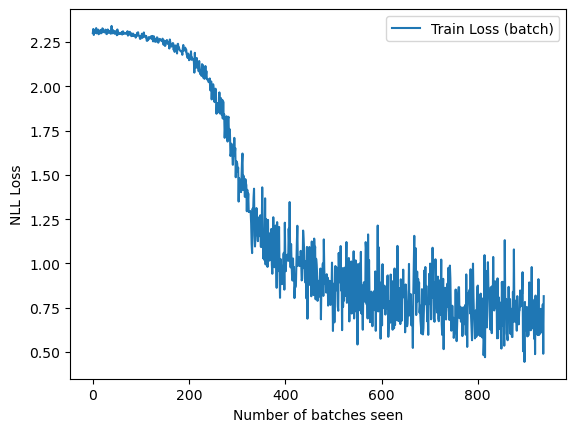

In [ ]:
# Plot losses
xrange = range(len(batch_losses))
_ = plt.plot(xrange, batch_losses)
_ == plt.legend(["Train Loss (batch)", "Test Loss (dataset)"], loc="upper right")
_ = plt.xlabel("Number of batches seen")
_ = plt.ylabel("NLL Loss")

In [ ]:
# # Plot alpha
# def plot_alphas(batch_alpha_0, batch_alpha_1, batch_alpha_2):

#     xrange = range(len(batch_alpha_0))
#     _ = plt.plot(xrange, batch_alpha_0, color="blue", label="Alpha 0")
#     _ = plt.plot(xrange, batch_alpha_1, color="red", label="Alpha 1")
#     _ = plt.plot(xrange, batch_alpha_2, color="green", label="Alpha 2")
#     _ = plt.xlabel("Number of seen batches")
#     _ = plt.ylabel("Alpha", rotation=0, labelpad=20)
#     plt.legend()
#     plt.show()

# plot_alphas(batch_alpha_0, batch_alpha_1, batch_alpha_2)

In [ ]:
print(type(batch_alpha_0))
print(type(batch_alpha_0[0]))
print(batch_alpha_0[0].dtype)

<class 'list'>
<class 'torch.Tensor'>
torch.float32


In [ ]:
print(f"Minimum of alpha0 = {th.min(th.stack(batch_alpha_0), dim=0)}")
print(f"Minimum of alpha1 = {th.min(th.stack(batch_alpha_1), dim=0)}")
print(f"Minimum of alpha2 = {th.min(th.stack(batch_alpha_2), dim=0)}")

Minimum of alpha0 = torch.return_types.min(
values=tensor(0.),
indices=tensor(378))
Minimum of alpha1 = torch.return_types.min(
values=tensor(0.),
indices=tensor(299))
Minimum of alpha2 = torch.return_types.min(
values=tensor(0.0587),
indices=tensor(937))


## Plotting for different values of alpha

In [ ]:
def plot_alphas(ax, batch_alpha_0, batch_alpha_1, batch_alpha_2):
    xrange = range(len(batch_alpha_0))
    ax.plot(xrange, batch_alpha_0, color="blue", label="Alpha 0")
    ax.plot(xrange, batch_alpha_1, color="red", label="Alpha 1")
    ax.plot(xrange, batch_alpha_2, color="green", label="Alpha 2")
    ax.set_xlabel("Number of seen batches")
    ax.set_ylabel("Alpha", rotation=0, labelpad=20)
    ax.legend(loc="upper right")
    # ax.set_title(
    #     f"Alpha0: {round(batch_alpha_0[0].item(), 2)}, Alpha1: {round(batch_alpha_0[1].item(), 2)}, Alpha2: {round(batch_alpha_0[2].item(), 2)}",
    #     fontweight="bold",
    # )
    return ax

In [ ]:
# alpha_range = np.arange(start=0, stop=1, step=0.05)

# lam = Lambda
# fig, ax = plt.subplots(3, 3, figsize=(20, 20))
# ax = ax.flatten()
# for i in range(9):
#     alpha0 = np.random.choice(alpha_range, size=1).astype(float)
#     alpha1 = np.random.choice(alpha_range, size=1).astype(float)
#     alpha2 = np.random.choice(alpha_range, size=1).astype(float)

#     model = Classifier_Net(alpha0, alpha1, alpha2)

#     optimizer = th.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

#     batch_losses, b_alpha_0, b_alpha_1, b_alpha_2 = train_model(
#         model, EPOCHS, optimizer=optimizer, loss_function=loss_function, Lambda=lam
#     )

#     ax[i] = plot_alphas(ax[i], b_alpha_0, b_alpha_1, b_alpha_2)

# fig.suptitle(f"Alpha values for lambda = {lam}", size = 16)
# plt.legend()
# plt.show()

In [ ]:
alpha_range = np.arange(start=0, stop=1, step=0.05)
lambda_range = np.arange(start=0.005, stop=0.05, step=0.005)
df = pd.DataFrame(columns=["lambda", "alpha0", "alpha1", "alpha2", "iteration"])

for lam in lambda_range:
    for i in range(6):
        alpha0 = np.random.choice(alpha_range, size=1).astype(float)
        alpha1 = np.random.choice(alpha_range, size=1).astype(float)
        alpha2 = np.random.choice(alpha_range, size=1).astype(float)
        model = Classifier_Net(alpha0, alpha1, alpha2)

        optimizer = th.optim.SGD(
            model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM
        )

        batch_losses, b_alpha_0, b_alpha_1, b_alpha_2 = train_model(
            model, EPOCHS, optimizer=optimizer, loss_function=loss_function, Lambda=lam
        )
        df_temp = pd.DataFrame(
            {
                "lambda": lam,
                "alpha0": [round(tensor.item(), 4) for tensor in b_alpha_0],
                "alpha1": [round(tensor.item(), 4) for tensor in b_alpha_1],
                "alpha2": [round(tensor.item(), 4) for tensor in b_alpha_2],
                "iteration": i,
            }
        )
        df = pd.concat([df, df_temp], ignore_index=True)
        df_temp.iloc[:, :] = None

    # Appending all batches (this should stay outside the loop)
    # df = df.append(rows_to_append, ignore_index=True)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Exporting dataframe to fileù
df.to_csv('./alphas_df.csv', index=False)

In [ ]:
df['iteration'].unique()

array([0, 1, 2], dtype=object)

In [ ]:
condition = ()
df[df["iteration"] == 2]

,lambda,alpha0,alpha1,alpha2,iteration
1876,0.005,0.0000,0.1000,0.1500,2
1877,0.005,0.0000,0.1000,0.1500,2
1878,0.005,0.0001,0.1000,0.1500,2
1879,0.005,0.0002,0.1000,0.1499,2
1880,0.005,0.0003,0.1001,0.1499,2
...,...,...,...,...,...
5623,0.010,0.1683,0.0000,0.0000,2
5624,0.010,0.1681,0.0000,0.0000,2
5625,0.010,0.1678,0.0000,0.0000,2
5626,0.010,0.1676,0.0001,0.0002,2


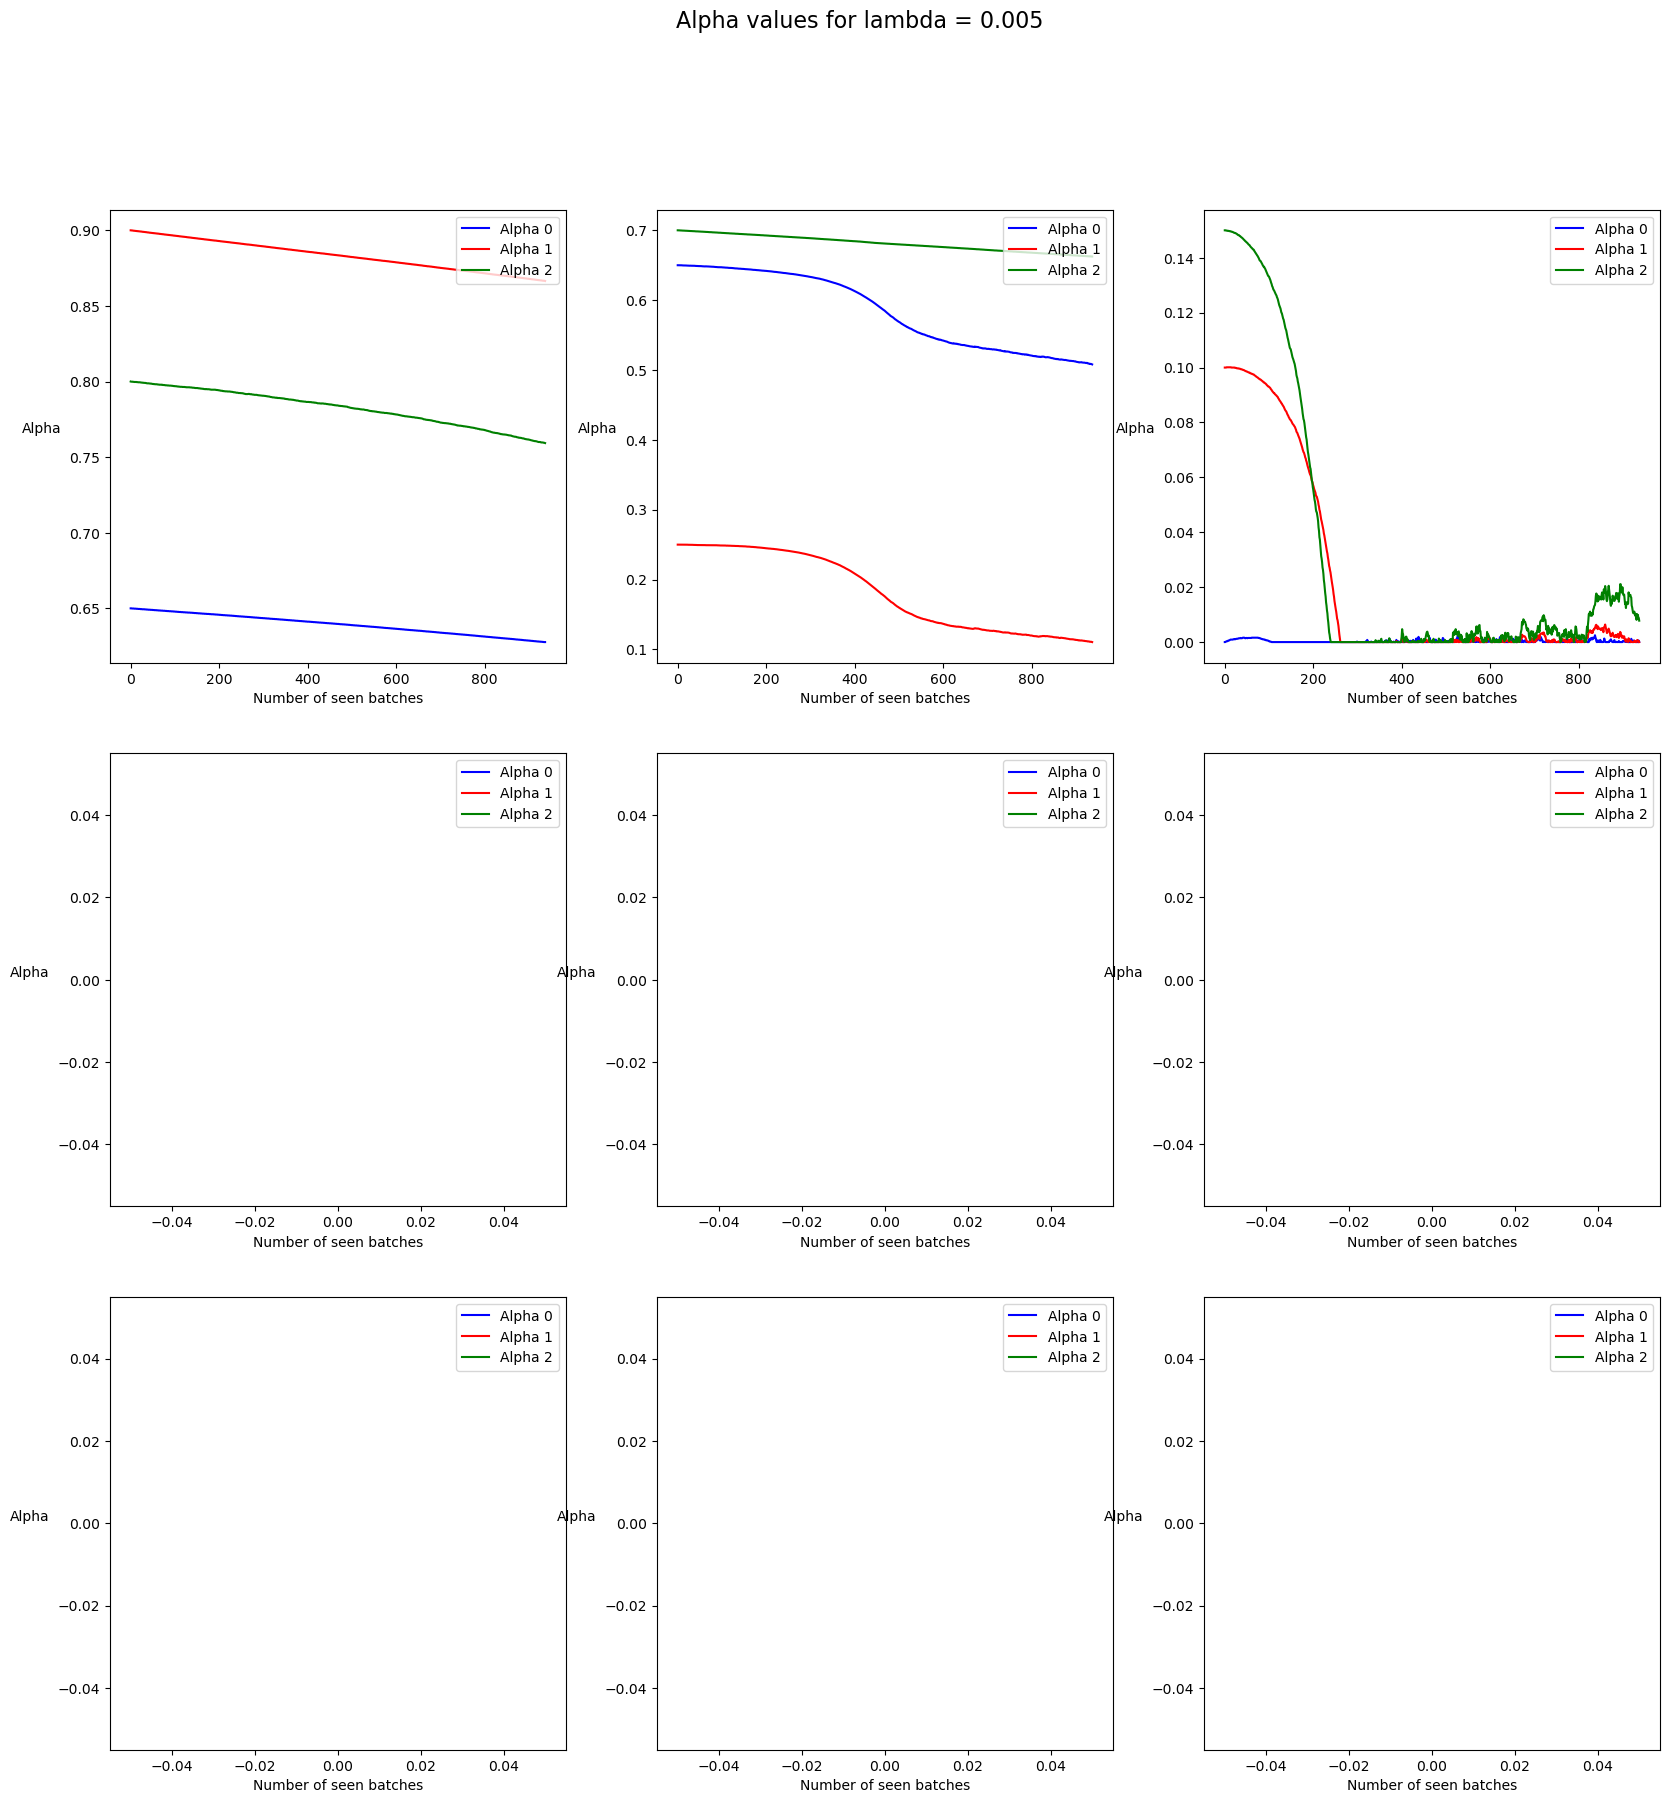

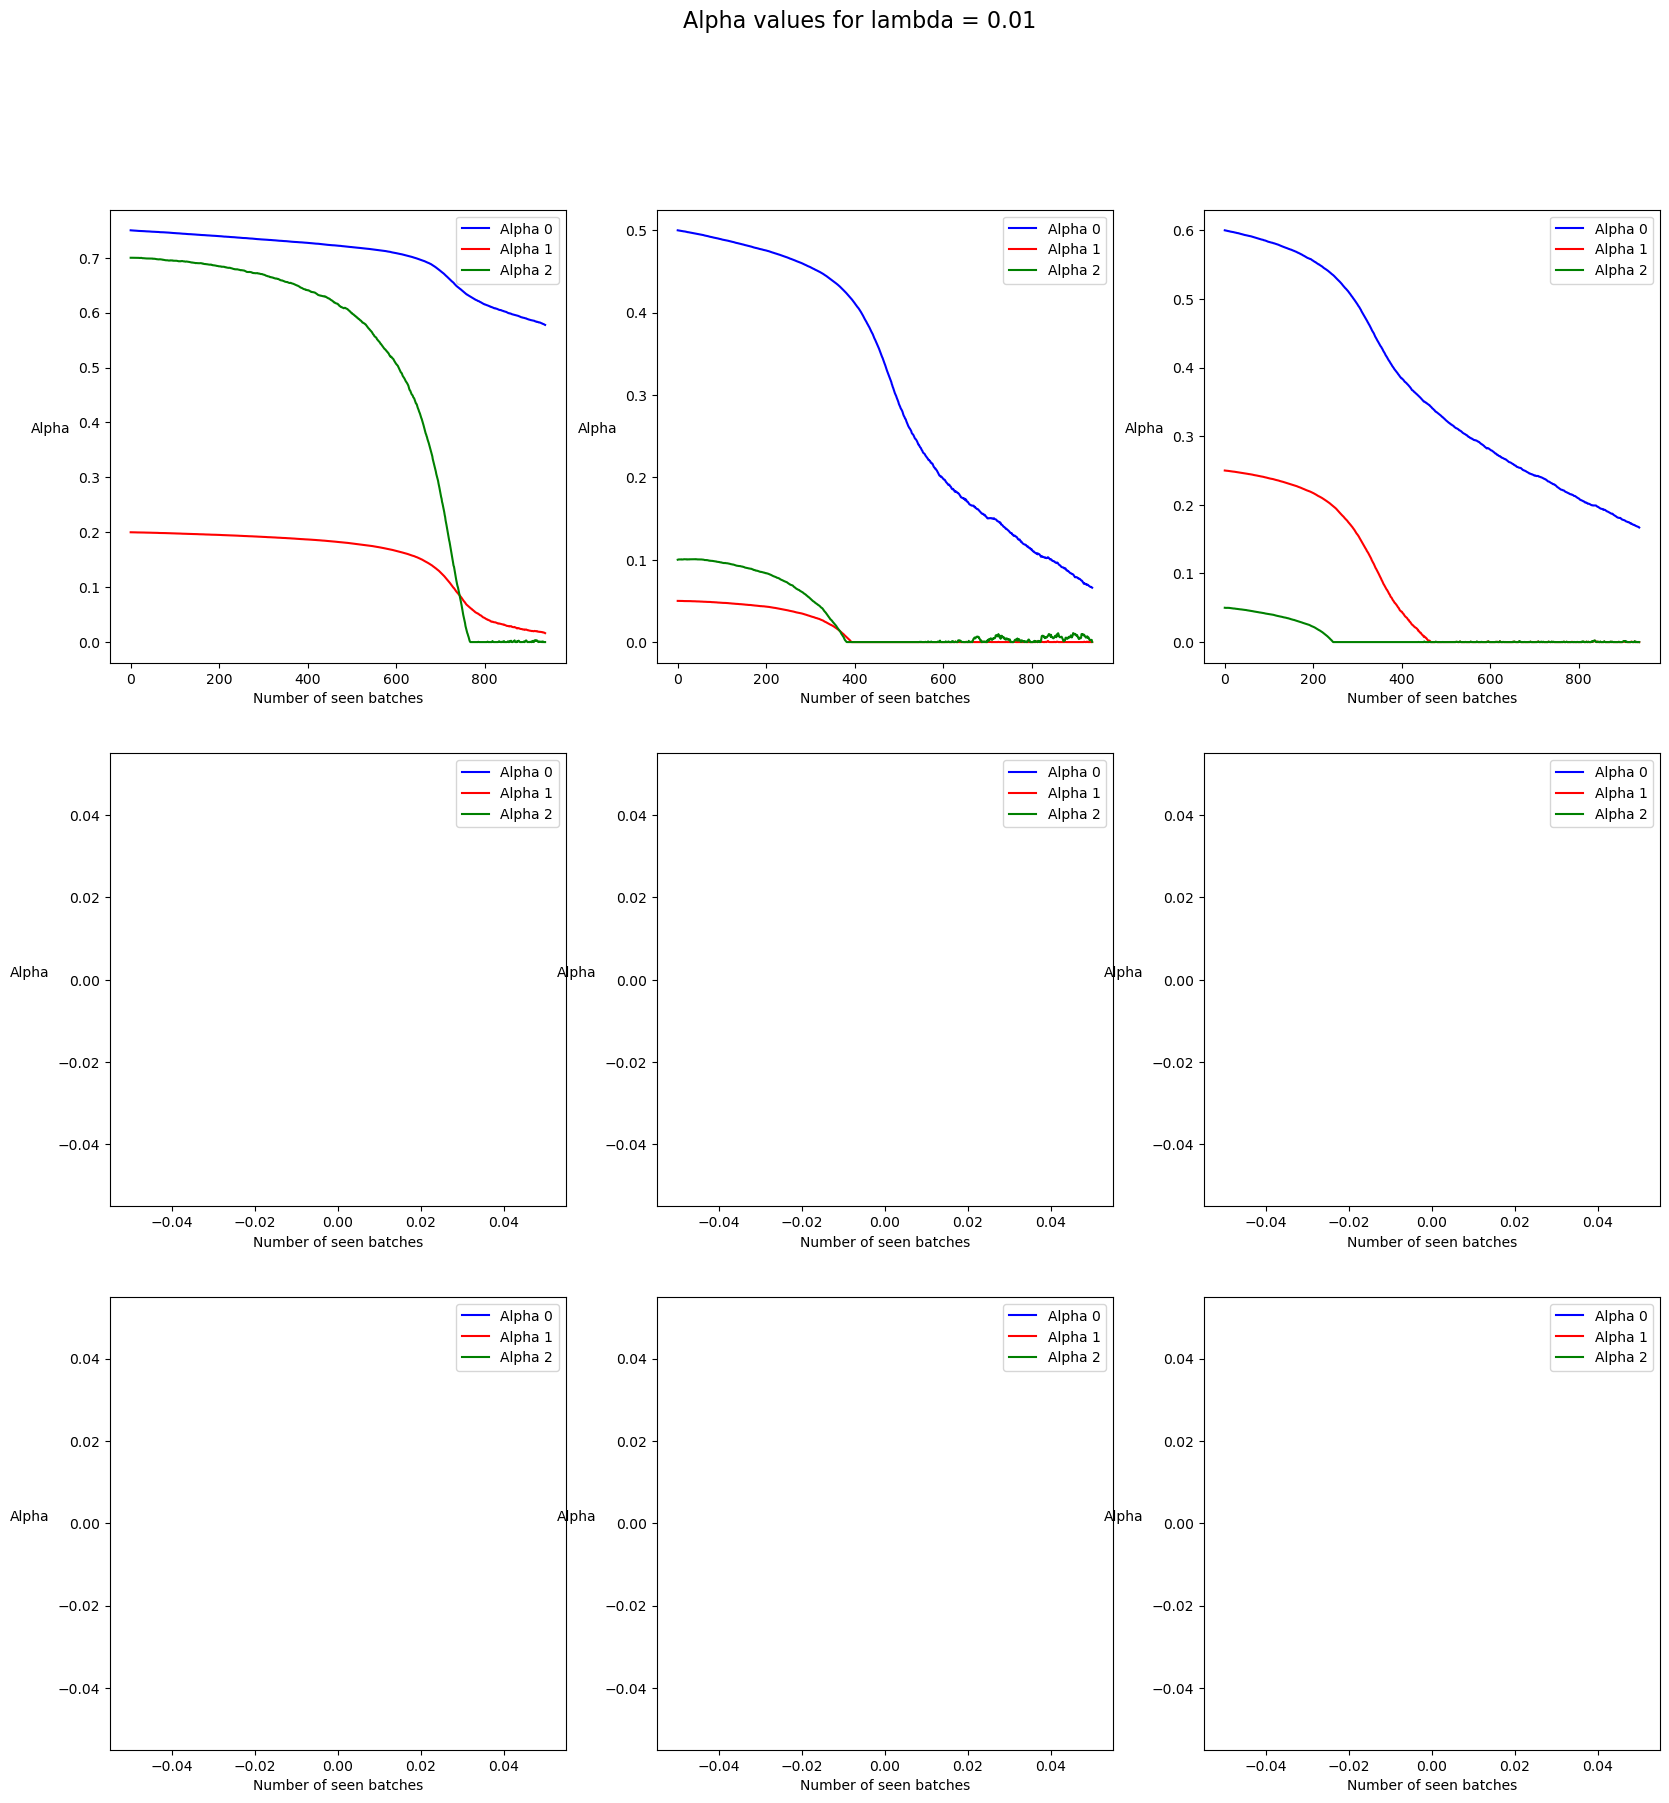

In [ ]:
for lam in lambda_range:
    fig, ax = plt.subplots(2, 3, figsize=(20, 20), dpi = 200)
    ax = ax.flatten()
    for i in range(6):
        condition = (df["lambda"] == lam) & (df["iteration"] == i)
        ax[i] = plot_alphas(
            ax[i],
            df.loc[condition, "alpha0"],
            df.loc[condition, "alpha1"],
            df.loc[condition, "alpha2"],
        )
    fig.suptitle(f"Alpha values for lambda = {lam}", size=16)
    plt.legend()
    plt.show()

# What should I do now?
First, check that the network structure makes sense (are the #relus right and at the right place?). Then, make lots of plots, even for different values of lambda

After that, decide if:
1) at some #epochs you want all of the alphas to be either 0 or 1 -> set the lambda that multiplies the alphas which are still in between 0 and 1 at that #epochs to 0 (you probably need a separate lambda for alpha in this case)
2) don't do 1) and see if the alphas cluster at some levels, maybe 2 or 3 of them go around 0.3 and some go around 0.7 while the rest go to 0 or 1. This could be interesting to see

## Trying to see the network work

Real label: T-shirt/top
prediction: tensor([[ -3.3032,  -2.2928,  -7.5210,  -0.1858,  -4.2125, -21.2981,  -4.1149,
         -14.2996,  -8.7882, -15.1382]])
Predicted class: Dress


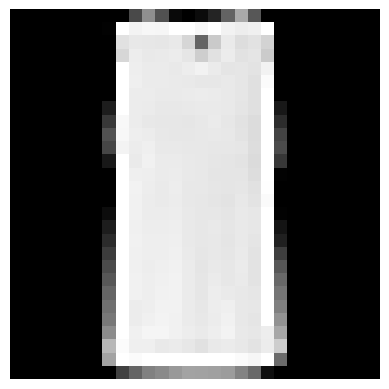

In [ ]:
# get single test image
dataiter = test_loader.__iter__()
images, labels = dataiter.__next__()

idx = np.random.choice(images.shape[0])
imshow(images[idx])
print(f"Real label: {description[labels[idx].item()]}")
prediction, _ = model(images[idx])
print(f"prediction: {prediction.detach()}")
predicted_class = th.argmax(prediction, dim=1)
print(f"Predicted class: {description[predicted_class.item()]}")